In [1]:
!pip3 install torch torchvision torchaudio
!pip install pytorch-msssim
from pytorch_msssim import ms_ssim

In [2]:
!pip install pytorch-fid

In [3]:
import scipy
from pytorch_fid.inception import InceptionV3

In [4]:
def calculate_activation_statistics(images, batch_size, device):
    dims=2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    model.eval()
    act=np.empty((len(images), dims))
    
    images.to(device)
    pred = model(images)[0]

    # If model output is not scalar, apply global spatial average pooling.
    # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [5]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = scipy.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [6]:
def calculate_fretchet(images_real,images_fake):
     mu_1,std_1=calculate_activation_statistics(images_real, batch_size, device)
     mu_2,std_2=calculate_activation_statistics(images_fake, batch_size, device)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [7]:
import os
import glob
from math import floor
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as utils

In [9]:
from torchvision.utils import save_image
from torchvision.utils import make_grid

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
class LinnaeusDataset(Dataset):
    def __init__(self, all_data_path, transform=None):
        self.all_data_path=all_data_path
        
        self.all_image_paths = list()
        self.all_classes = list()

        for data_path in glob.glob(self.all_data_path + '/*'):
          self.all_classes.append(data_path.split('/')[-1])
          self.all_image_paths.append(glob.glob(data_path + '/*'))

        self.image_paths = list(flatten(self.all_image_paths))
        self.transform = transform

        self.idx_to_class = {i:j for i, j in enumerate(self.all_classes)}
        self.class_to_idx = {value:key for key,value in self.idx_to_class.items()}
        
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = mpimg.imread(image_filepath)
        
        label = image_filepath.split('/')[-2]
        label = self.class_to_idx[label]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [12]:
class ACDiscriminator(nn.Module):
    def __init__(self, nclass):
        super(ACDiscriminator, self).__init__()
      
        self.Cin=3
        self.Cmid=16
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels=self.Cin, out_channels=self.Cmid, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                #128->64
                
                nn.Conv2d(in_channels=self.Cmid, out_channels=self.Cmid*2, kernel_size=4, stride=2,padding=1),
                nn.BatchNorm2d(self.Cmid*2),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),
                #64->32
            
                nn.Conv2d(in_channels=self.Cmid*2, out_channels=self.Cmid*4, kernel_size=4, stride=2,padding=1),
                nn.BatchNorm2d(self.Cmid*4),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),
                #32->16
                
                nn.Conv2d(in_channels=self.Cmid*4, out_channels=self.Cmid*8, kernel_size=4,stride=2,padding=1),
                nn.BatchNorm2d(self.Cmid*8),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),
                #16->8

                nn.Conv2d(in_channels=self.Cmid*8, out_channels=self.Cmid*16, kernel_size=4,stride=2,padding=1),
                nn.BatchNorm2d(self.Cmid*16),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Dropout(p=0.5),
                #8->4
        
                nn.Conv2d(in_channels=self.Cmid*16, out_channels=self.Cmid*64, kernel_size=4,stride=1,padding=0),
                nn.BatchNorm2d(self.Cmid*64),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                #4->1
                )
        
        
        self.fc_linear = nn.Linear(self.Cmid*64,  256)
        self.fc_class =  nn.Linear(256, nclass)
        self.fc_logsoftmax= nn.LogSoftmax(dim=1)

        self.fc_isreal = nn.Linear(256, 1)
        self.fc_sigmoid= nn.Sigmoid()

    def forward(self, input):
        bz=input.size()[0]
        out=self.conv(input)
        out=out.view(bz,-1)
        
        out = self.fc_linear(out)

        fc_class= self.fc_logsoftmax(self.fc_class(out))
        fc_isreal = self.fc_sigmoid(self.fc_isreal(out))
        
        return fc_class, fc_isreal

In [13]:
class ACGenerator(nn.Module):
    def __init__(self, nz):
        super(ACGenerator, self).__init__()
        self.nz=nz
        
        #linear
        self.fc = nn.Linear(self.nz,512)
        
        self.tconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=1024, kernel_size=4, stride=1,padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            #1->4
            
            nn.ConvTranspose2d(in_channels=1024,out_channels=512, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #4->8
        
            nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #8->16
        
            nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #16->32
        
            nn.ConvTranspose2d(in_channels=128,out_channels=64, kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #32->64
            
            nn.ConvTranspose2d(in_channels=64,out_channels=3, kernel_size=4, stride=2,padding=1),
            #64->128
            
            nn.Tanh()
        )
        
        
    def forward(self, input):
        input = input.view(-1,self.nz)
        out = self.fc(input).view(-1,512,1,1)
        out = self.tconv(out)
        return out

In [15]:
def training(iterations, dataloader, dis_model, gen_model, optD, optG, class_loss, label_loss,nz, nclass, device):
    
    for epoch in range(2001,iterations+1):
        total_dis_real_loss=0
        total_dis_fake_loss=0
        total_gen_loss=0
        
        total_dis_real_loss_list=list()
        total_dis_fake_loss_list=list()
        total_gen_loss_list=list()
        
        real_image_dis_acc=0
        fake_image_dis_acc=0

        for img, img_class in dataloader:
            img = img.to(device)
            img_class = img_class.to(device)

            #train the discriminator
            optD.zero_grad()

            #real data is 1 and fake data is 0
            real = Variable(torch.ones(img.size()[0],1).to(device))
            fake = Variable(torch.zeros(img.size()[0],1).to(device))

            pred_img_class, pred_img_valid = dis_model(img)
            loss_class_real= class_loss(pred_img_class, img_class)
            loss_label_real= label_loss(pred_img_valid, real)
            loss_dis_real= loss_class_real+loss_label_real
            loss_dis_real.backward()
            optD.step()
            

            latent_z = torch.randn(img.size()[0],nz).to(device)
            fake_class =torch.randint(0,nclass, (img.size()[0],)).to(device)
            latent_z[:,-nclass:]=F.one_hot(fake_class, num_classes=nclass)

            fake_img = gen_model(latent_z)
            
            pred_fake_img_class, pred_fake_img_valid=dis_model(fake_img.detach())
            
            loss_class_fake = class_loss(pred_fake_img_class, fake_class)
            loss_label_fake = label_loss(pred_fake_img_valid, fake)
            loss_dis_fake=loss_class_fake +loss_label_fake
            loss_dis_fake.backward()
            optD.step()

            loss_dis = (loss_dis_fake+loss_dis_real)/2
 
            #train the generator
            gen_model.zero_grad()
            pred_gen_img_class, pred_gen_img_label = dis_model(fake_img)
            
            loss_class_gen = class_loss(pred_gen_img_class, fake_class)
            loss_label_gen = label_loss(pred_gen_img_label, real)
            loss_gen =loss_class_gen +loss_label_gen
            
            loss_gen.backward()
            optG.step()
            

            #loss for discrininator
            total_dis_real_loss+=loss_dis_real.item()
            real_image_dis_acc+=torch.sum(torch.argmax(pred_img_class,dim=1)==img_class)
            
            total_dis_fake_loss+=loss_dis_fake.item()
            fake_image_dis_acc+=torch.sum(torch.argmax(pred_fake_img_class,dim=1)==fake_class)
            
            #loss for generater
            total_gen_loss+=loss_gen.item()

        if epoch%50==0:  
            print('Epoch {} Discriminator loss real {:.4f}, Discriminator loss fake {:.4f} Generator loss {:.4f}'.format(epoch, total_dis_real_loss/len(dataloader.dataset) ,total_dis_fake_loss/len(dataloader.dataset), total_gen_loss/len(dataloader.dataset)))
            print('Epoch {} Discriminator real acc {:.3f} and fake acc {:.3f}'.format(epoch, real_image_dis_acc/len(dataloader.dataset),fake_image_dis_acc/len(dataloader.dataset)))    
            
            fretchet_dist_RF=calculate_fretchet(img,fake_img)
            print('Epoch {} Fretchet_Distance between Real and Fake Image {:.3f}'.format(epoch,fretchet_dist_RF))
            
            #generate class 1th
            eval_z = torch.randn(32,nz).to(device)
            eval_class = torch.randint(0, nclass, (32,))
            eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
            eval_z =eval_z.to(device)
            
            with torch.no_grad():
                eval_img = gen_model(eval_z)

            #inverse transform of image
            inv_transform = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2))])
            inv_img=inv_transform(eval_img)
            utils.save_image(inv_img.float(), "/kaggle/working/eval_images_{}.png".format(epoch))
        
        
            torch.save(gen_model.state_dict(), f'/kaggle/working/ACGen_128_{epoch}_best.pth')
            torch.save(dis_model.state_dict(), f'/kaggle/working/ACDis_128_{epoch}_best.pth')
        
        
        total_dis_real_loss_list.append(total_dis_real_loss/len(dataloader))
        total_dis_fake_loss_list.append(total_dis_fake_loss/len(dataloader))
        total_gen_loss_list.append(total_gen_loss/len(dataloader))
    
    
    return total_dis_real_loss_list, total_dis_fake_loss_list, total_gen_loss_list

In [16]:
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
nz=40
nclass=4

lr=0.0002
iterations=2500
batch_size = 32

all_data_path ='/kaggle/input/lin-128/Linnaeus_5_128X128/train' 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
LnnDataset=LinnaeusDataset(all_data_path,transform)
trainloader = torch.utils.data.DataLoader(LnnDataset, batch_size=batch_size, shuffle=True)

In [21]:
dis_model = ACDiscriminator(nclass).to(device)
gen_model = ACGenerator(nz).apply(initialize_weights).to(device)

model_exist=True
if model_exist:
  gen_model.load_state_dict(torch.load('/kaggle/working/ACGen_128_1000_best.pth'))
  gen_model.to(device)
  dis_model.load_state_dict(torch.load('/kaggle/working/ACDis_128_1000_best.pth'))
  dis_model.to(device)

label_loss=nn.BCELoss()
class_loss=nn.NLLLoss()

optD = optim.Adam(dis_model.parameters(), lr=lr)
optG = optim.Adam(gen_model.parameters(), lr=lr)

dis_real_loss, dis_fake_loss, gen_loss=training(iterations, trainloader, dis_model, gen_model, optD, optG, class_loss, label_loss, nz, nclass, device)

KeyboardInterrupt: 

In [23]:
gen_model = ACGenerator(nz).apply(initialize_weights)
gen_model.load_state_dict(torch.load('/kaggle/working/ACGen_128_900_best.pth'))

<All keys matched successfully>

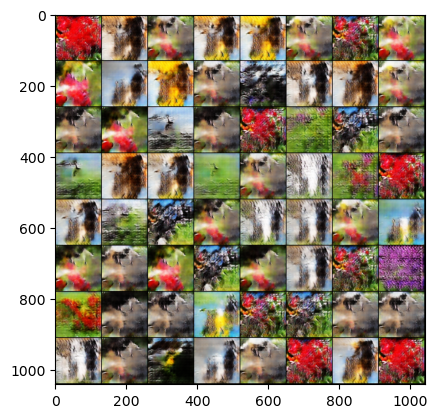

In [24]:
eval_z = torch.randn((64,nz))
eval_class = torch.randint(0,4,(64,))
eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
with torch.no_grad():
    eval_img = gen_model(eval_z)
    
    #inverse transform of image
    inv_transform = transforms.Compose([transforms.Normalize((-1, -1, -1), (2, 2, 2))])
    inv_img=inv_transform(eval_img)
    utils.save_image(inv_img.float(), f"/kaggle/working/generate.png")
    image = mpimg.imread("/kaggle/working/generate.png")
    plt.imshow(image)

In [25]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
def cal_ms_ssim(img_real,img_fake):
    up = nn.Upsample(size=(256,256), mode='bilinear',align_corners=True)
    img_real =up(img_real.type(torch.DoubleTensor))
    img_fake =up(img_fake.type(torch.DoubleTensor))
  
    ms_ssim_module = MS_SSIM(data_range=1,size_average=True,channel=3)
    ms_ssim_score=ms_ssim_module(img_real,img_fake)
    return ms_ssim_score

In [26]:
with torch.no_grad():
    eval_z=torch.randn((32,nz))
    eval_class = torch.randint(0,4, (32,))
    eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
    eval_img1 = gen_model(eval_z)
    
    eval_z=torch.randn((32,nz))
    eval_class = torch.randint(0,4, (32,))
    eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)
    eval_img2 = gen_model(eval_z)
    
    ssim_fake=cal_ms_ssim((eval_img1+1)/2,(eval_img2+1)/2)
    print(ssim_fake)

tensor(0.2138, dtype=torch.float64)


In [27]:
img = img.to(device)
img_class = img_class.to(device)
eval_z = torch.randn((32,nz))
eval_class = torch.randint(0,4,(32,))
eval_z[:,-nclass:]=F.one_hot(eval_class, num_classes=nclass)

pre_img=None
for img, img_class in trainloader:
    img = img.to(device)
    img_class = img_class.to(device)

    with torch.no_grad():
        eval_img = gen_model(eval_z)
 
    if pre_img!=None:
        ssim_real=cal_ms_ssim((img+1)/2,(pre_img+1)/2)
        print("ssim_real",ssim_real)
        ssim_fake=cal_ms_ssim((img+1)/2,(eval_img+1)/2)
        print("ssim_fake",ssim_fake)
        print("ssim_fake/ssim_real",ssim_fake/ssim_real)
    pre_img=img

NameError: name 'img' is not defined